# **MODELING**

## **IMPORT LIBRARIES**

In [1]:
# Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import pickle
import phik
import warnings
warnings.filterwarnings('ignore')

# Libraries for modeling
from sklearn.model_selection import train_test_split
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

## **DATA LOADING**

In [2]:
# Import dataset
df = pd.read_csv("https://raw.githubusercontent.com/FTDS-assignment-bay/p2-final-project-rmt-040-final-group03/refs/heads/main/cleaned_data.csv")
df.head()

,units_sold,discount_applied,revenue,clicks,impressions,conversion_rate,category,region,ad_ctr,ad_cpc,ad_spend,transaction_date_update
0,134,0.14,305.54,11,65,0.17,Electronics,Europe,0.0180,0.55,9.90,Oct-2024
1,109,0.30,1102.19,15,201,0.07,Home Appliances,Asia,0.1589,0.40,63.56,Oct-2024
2,116,0.04,471.29,16,199,0.08,Toys,Asia,0.0596,1.50,89.40,Apr-2024
3,125,0.20,980.26,12,355,0.03,Clothing,Europe,0.0444,0.44,19.54,Aug-2024
4,132,0.07,803.76,44,355,0.12,Books,North America,0.1270,0.53,67.31,May-2024


In [3]:
# Drop column transaction date
df.drop("transaction_date_update", axis=1, inplace=True)
df

,units_sold,discount_applied,revenue,clicks,impressions,conversion_rate,category,region,ad_ctr,ad_cpc,ad_spend
0,134,0.14,305.54,11,65,0.17,Electronics,Europe,0.0180,0.55,9.90
1,109,0.30,1102.19,15,201,0.07,Home Appliances,Asia,0.1589,0.40,63.56
2,116,0.04,471.29,16,199,0.08,Toys,Asia,0.0596,1.50,89.40
3,125,0.20,980.26,12,355,0.03,Clothing,Europe,0.0444,0.44,19.54
4,132,0.07,803.76,44,355,0.12,Books,North America,0.1270,0.53,67.31
...,...,...,...,...,...,...,...,...,...,...,...
4995,183,0.20,173.70,23,299,0.08,Books,North America,0.1459,0.54,78.79
4996,151,0.20,61.13,19,440,0.04,Clothing,Asia,0.1036,1.21,125.36
4997,174,0.04,274.68,11,10,1.10,Toys,Europe,0.1758,1.16,203.93
4998,180,0.12,51.23,12,490,0.02,Books,North America,0.0853,0.28,23.88


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   units_sold        5000 non-null   int64  
 1   discount_applied  5000 non-null   float64
 2   revenue           5000 non-null   float64
 3   clicks            5000 non-null   int64  
 4   impressions       5000 non-null   int64  
 5   conversion_rate   5000 non-null   float64
 6   category          5000 non-null   object 
 7   region            5000 non-null   object 
 8   ad_ctr            5000 non-null   float64
 9   ad_cpc            5000 non-null   float64
 10  ad_spend          5000 non-null   float64
dtypes: float64(6), int64(3), object(2)
memory usage: 429.8+ KB


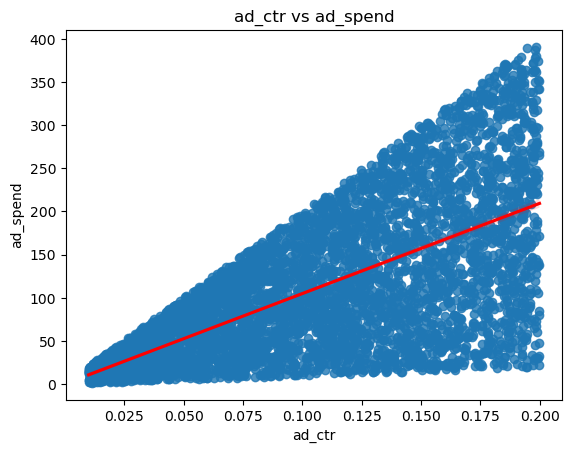

In [5]:
# Checking the linear relationship between ad_ctr and ad_spend
sns.regplot(x = df['ad_ctr'], y = df['ad_spend'], line_kws = {'color' : 'red'})
plt.title("ad_ctr vs ad_spend")
plt.show()

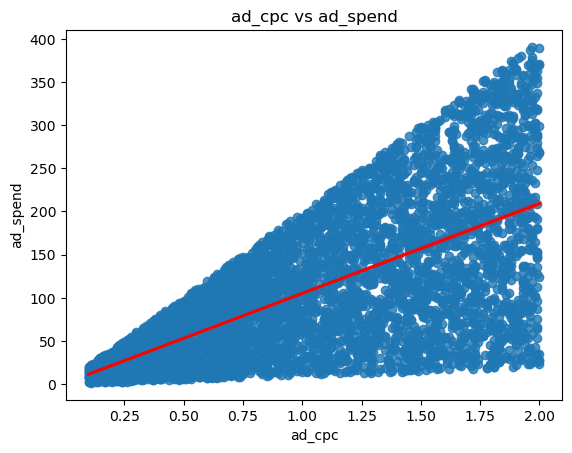

In [6]:
# Checking the linear relationship between ad_cpc and ad_spend
sns.regplot(x = df['ad_cpc'], y = df['ad_spend'], line_kws = {'color' : 'red'})
plt.title("ad_cpc vs ad_spend")
plt.show()

## **DATA PREPROCESSING**

### **Data Preparation**

In [7]:
# Splitting data
X = df.drop(columns="ad_spend")
y = df["ad_spend"]
X.head()

,units_sold,discount_applied,revenue,clicks,impressions,conversion_rate,category,region,ad_ctr,ad_cpc
0,134,0.14,305.54,11,65,0.17,Electronics,Europe,0.0180,0.55
1,109,0.30,1102.19,15,201,0.07,Home Appliances,Asia,0.1589,0.40
2,116,0.04,471.29,16,199,0.08,Toys,Asia,0.0596,1.50
3,125,0.20,980.26,12,355,0.03,Clothing,Europe,0.0444,0.44
4,132,0.07,803.76,44,355,0.12,Books,North America,0.1270,0.53


In [8]:
# Cardinality Checking
df.nunique()

units_sold           204
discount_applied      31
revenue             4777
clicks                50
impressions          490
conversion_rate      197
category               5
region                 3
ad_ctr              1770
ad_cpc               191
ad_spend            4446
dtype: int64

Dataset categorical columns have low cardinality, which is good. So we can move to Columns Splitting.

In [9]:
# Splitting data train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 40)
print('Train Size: ', X_train.shape)
print('Test Size: ', X_test.shape)

Train Size:  (4000, 10)
Test Size:  (1000, 10)


### **Handling Outliers**

In [10]:
# Numeric & categorical columns splitting
cat_cols = ["category", "region"]
num_cols = ["units_sold", "discount_applied", "revenue", "clicks", "impressions", "conversion_rate", "ad_ctr", "ad_cpc"]

In [11]:
# Outliers checking
skewness_info = X_train[num_cols].skew()
skewness_info

units_sold          0.751406
discount_applied   -0.000263
revenue             1.438327
clicks             -0.025416
impressions         0.000796
conversion_rate     5.791569
ad_ctr             -0.011358
ad_cpc              0.027510
dtype: float64

In [12]:
normal_columns = []
skewed_columns = []
extreme_skewed_columns = []

# Loop through the skewness values and categorize the columns
for col, skewness in skewness_info.items():
    if skewness < -1.0 or skewness > 1.0:
        extreme_skewed_columns.append(col)
    elif abs(skewness) <= 0.5:
        normal_columns.append(col)
    else:
        skewed_columns.append(col)

# Print the columns in each category
print(f"Normal: {normal_columns}\nSkewed: {skewed_columns}\nExtreme Skewed: {extreme_skewed_columns}")

Normal: ['discount_applied', 'clicks', 'impressions', 'ad_ctr', 'ad_cpc']
Skewed: ['units_sold']
Extreme Skewed: ['revenue', 'conversion_rate']


In [13]:
# Capping outliers based on skewness score
normal_columns = ['discount_applied', 'clicks', 'impressions', 'ad_ctr', 'ad_cpc']
skewed_columns = ['units_sold']
extreme_skewed_columns = ['revenue', 'conversion_rate']

# Winsorizer for normal_columns
windsoriser1 = Winsorizer(capping_method='gaussian',
                          tail='both',
                          fold=3,
                          variables=normal_columns)

# Winsorizer for skewed_columns
windsoriser2 = Winsorizer(capping_method='iqr',
                          tail='both',
                          fold=1.5,
                          variables=skewed_columns)

# Winsorizer for extreme_skewed_columns
windsoriser3 = Winsorizer(capping_method='iqr',
                          tail='both',
                          fold=3,
                          variables=extreme_skewed_columns)

# Fit and transform for normal_columns
windsoriser1.fit(X_train)
X_train_capped = windsoriser1.transform(X_train)
X_test_capped = windsoriser1.transform(X_test)

# Fit and transform for skewed_columns
windsoriser2.fit(X_train_capped)
X_train_capped = windsoriser2.transform(X_train_capped)
X_test_capped = windsoriser2.transform(X_test_capped)

# Fit and transform for extreme_skewed_columns
windsoriser3.fit(X_train_capped)
X_train_capped = windsoriser3.transform(X_train_capped)
X_test_capped = windsoriser3.transform(X_test_capped)

In [14]:
# Checking outliers after capping
skewness_info = X_train_capped[num_cols].skew()
skewness_info

units_sold         -0.013548
discount_applied   -0.000263
revenue             0.975899
clicks             -0.025416
impressions         0.000796
conversion_rate     1.606801
ad_ctr             -0.011358
ad_cpc              0.027510
dtype: float64

In [15]:
# Concatenate X_train and y_train
concat_train = pd.concat([X_train_capped, y_train], axis=1)

# Show X_train
concat_train.head()

,units_sold,discount_applied,revenue,clicks,impressions,conversion_rate,category,region,ad_ctr,ad_cpc,ad_spend
2218,103.0,0.30,289.04,11,149,0.07,Toys,North America,0.0132,1.96,25.87
1708,151.0,0.27,462.57,21,298,0.07,Home Appliances,North America,0.1488,1.75,260.40
2456,67.0,0.08,361.79,46,458,0.10,Clothing,Europe,0.1484,0.26,38.58
4371,222.0,0.11,188.04,31,326,0.10,Toys,North America,0.0678,0.44,29.83
3474,122.0,0.16,128.53,44,177,0.25,Clothing,North America,0.1224,1.71,209.30


### **Feature Selection**

In [16]:
# Feature Selection
def compute_phik_correlation(dataframe, columns, target):
    subset = dataframe[columns]
    correlation_matrix = subset.phik_matrix()
    return correlation_matrix[target]

# Define the list of columns for each subset
columns = ['units_sold', 'discount_applied', 'revenue', 'clicks', 'impressions',
       'conversion_rate', 'category', 'region', 'ad_ctr', 'ad_cpc', 'ad_spend']
target = ['ad_spend']

# Compute Phi-K correlation for each set of columns and print
correlation = compute_phik_correlation(concat_train, columns, target)

# Print result
print(correlation)

interval columns not set, guessing: ['units_sold', 'discount_applied', 'revenue', 'clicks', 'impressions', 'conversion_rate', 'ad_ctr', 'ad_cpc', 'ad_spend']
                  ad_spend
units_sold        0.000000
discount_applied  0.000000
revenue           0.036464
clicks            0.000000
impressions       0.000000
conversion_rate   0.000000
category          0.019848
region            0.059973
ad_ctr            0.728081
ad_cpc            0.723600
ad_spend          1.000000


In [17]:
X_train_capped.drop(['units_sold', 'discount_applied', 'clicks', 'impressions', 'conversion_rate'], axis = 1, inplace = True)
X_test_capped.drop(['units_sold', 'discount_applied', 'clicks', 'impressions', 'conversion_rate'], axis = 1, inplace = True)
X_train_capped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 2218 to 3398
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   revenue   4000 non-null   float64
 1   category  4000 non-null   object 
 2   region    4000 non-null   object 
 3   ad_ctr    4000 non-null   float64
 4   ad_cpc    4000 non-null   float64
dtypes: float64(3), object(2)
memory usage: 187.5+ KB


Drop features that have zero (0) correlations to the target columns

### **Feature Transformation**

In [18]:
cat = ["category", "region"]
num = ["revenue","ad_ctr", "ad_cpc"]

In [19]:
# Feature scaling & encoding
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

preprocess = ColumnTransformer(
    transformers = [
        ('num',scaler,num),
        ('cat',ohe,cat)],
    remainder='passthrough')

## **MODELING**

Model definition using pipeline.

In [20]:
pipe_lr = make_pipeline(preprocess,LinearRegression())

In [21]:
pipe_knn = make_pipeline(preprocess, KNeighborsRegressor())

In [22]:
pipe_svr = make_pipeline(preprocess, SVR())

In [23]:
pipe_dt = make_pipeline(preprocess, DecisionTreeRegressor(random_state = 100))

In [24]:
pipe_rf = make_pipeline(preprocess, RandomForestRegressor(random_state = 100))

### **Cross Validation**

In [25]:
skfold = KFold(n_splits = 5, shuffle = True, random_state = 100)

cv_lr = cross_val_score(pipe_lr, X_train_capped, y_train, cv = skfold, scoring = 'neg_mean_absolute_error', n_jobs = -1)
cv_knn = cross_val_score(pipe_knn, X_train_capped, y_train, cv = skfold, scoring = 'neg_mean_absolute_error', n_jobs = -1)
cv_svr = cross_val_score(pipe_svr, X_train_capped, y_train, cv = skfold, scoring = 'neg_mean_absolute_error', n_jobs = -1)
cv_dt = cross_val_score(pipe_dt, X_train_capped, y_train, cv = skfold, scoring = 'neg_mean_absolute_error', n_jobs = -1)
cv_rf = cross_val_score(pipe_rf, X_train_capped, y_train, cv = skfold, scoring = 'neg_mean_absolute_error', n_jobs = -1)

In [26]:
cv_results = [cv_lr, cv_knn, cv_svr,cv_dt, cv_rf]
model_names = ["lr_model", "knn_model", "svr_model", "dt_model", "rf_model"]

# Save the result
results = []

for name, cv in zip(model_names, cv_results):
    mae_scores = -cv
    mean = mae_scores.mean()
    std = mae_scores.std()
    min_range = mean - std
    max_range = mean + std
    results.append({
        "Model": name,
        "Mean": round(mean, 5),
        "Std": round(std, 5),
        "MAE - Range": f"{round(min_range, 5)} - {round(max_range, 5)}"
    })

# Make DataFrame
df_scores = pd.DataFrame(results)
df_scores = df_scores.sort_values(by = ["Mean", "Std"], ascending = [True, True]).reset_index(drop = True)
print(df_scores)

# Show the best model
best_model = df_scores.loc[0, "Model"]
print(f"Best Model: {best_model}")

       Model      Mean      Std          MAE - Range
0   rf_model   1.24897  0.05525    1.19372 - 1.30422
1   dt_model   3.03296  0.10255     2.9304 - 3.13551
2  knn_model  11.67273  0.20687   11.46587 - 11.8796
3  svr_model  13.06115  0.59554  12.46561 - 13.65669
4   lr_model  22.69399  0.42971   22.26428 - 23.1237
Best Model: rf_model


### **Training**

In [27]:
pipe_rf.fit(X_train_capped, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['revenue', 'ad_ctr',
                                                   'ad_cpc']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['category', 'region'])])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=100))])

In [28]:
# Predict the data
y_train_pred = pipe_rf.predict(X_train_capped)
y_test_pred = pipe_rf.predict(X_test_capped)

## **MODEL EVALUATION**

In [29]:
# Define a function to save the evaluation results
def performance_report(all_reports, y_train, y_train_pred, y_test, y_test_pred, name):
    score_reports = {
      "Train MAE": round(mean_absolute_error(y_train, y_train_pred), 5),
      "Test MAE": round(mean_absolute_error(y_test, y_test_pred), 5),

      "Train R2": round(r2_score(y_train, y_train_pred), 5),
      "Test R2": round(r2_score(y_test, y_test_pred), 5)
    }

    all_reports[name] = score_reports
    return all_reports

In [30]:
all_reports = {}
all_reports = performance_report(all_reports, y_train, y_train_pred, y_test, y_test_pred, "RandomForestRegressor before tuned")

# Saved as a pandas DataFrame
pd.DataFrame(all_reports)

,RandomForestRegressor before tuned
Train MAE,0.44060
Test MAE,1.13597
Train R2,0.99994
Test R2,0.99966


## **HYPERPARAMETER TUNING**

### **Training**

In [31]:
# Set the parameters for the RandomForestRegressor model
param_grid_loc = {
    'randomforestregressor__n_estimators': [100, 200, 300], # the number of trees
    'randomforestregressor__max_depth': [10, 20], # max depth of the tree
    'randomforestregressor__min_samples_split': [2, 5, 10], # min number of samples required to split an internal node
    'randomforestregressor__min_samples_leaf': [1, 3, 5], # min number of samples required to be at leaf node
    'randomforestregressor__max_features': [1.0, 0.6] # number of features consider when looking for the best split
}

# Hyperparameter tuning with GridSearchCV
grid_search_rf = GridSearchCV(pipe_rf,
                              param_grid = param_grid_loc,
                              scoring = 'neg_mean_absolute_error',
                              cv = 5,
                              verbose = 2,
                              n_jobs = -1)

grid_search_rf.fit(X_train_capped, y_train)

# Show the best parameters
print("Best parameters for RandomForestRegressor:", grid_search_rf.best_params_)

# Show the best r2 score
print("Best r2 score from cross validation:", round(-grid_search_rf.best_score_, 5))

# Saving the best model
best_rf_model = grid_search_rf.best_estimator_

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters for RandomForestRegressor: {'randomforestregressor__max_depth': 20, 'randomforestregressor__max_features': 1.0, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 300}
Best r2 score from cross validation: 1.20246


### **Evaluation**

In [32]:
y_train_pred_tuned = best_rf_model.predict(X_train_capped)
y_test_pred_tuned = best_rf_model.predict(X_test_capped)

In [33]:
all_reports = {}
all_reports = performance_report(all_reports, y_train, y_train_pred, y_test, y_test_pred, "RandomForestRegressor before tuned")
all_reports = performance_report(all_reports, y_train, y_train_pred_tuned, y_test, y_test_pred_tuned, "RandomForestRegressor after tuned")

pd.DataFrame(all_reports)

,RandomForestRegressor before tuned,RandomForestRegressor after tuned
Train MAE,0.44060,0.39974
Test MAE,1.13597,1.07711
Train R2,0.99994,0.99995
Test R2,0.99966,0.99969


**MAE:** MAE digunakan untuk mengukur rata-rata kesalahan yang bersifat mutlak dari prediksi tersebut. Semakin kecil nilai MAE, semakin baik kualitas model yang dibuat.  
**R2:** R2-Score adalah ukuran mengenai seberapa dekat nilai prediksi dari suatu model cocok dengan nilai yang diamati. Nilai R2 ideal suatu model adalah 1 yang menunjukkan bahwa model tersebut dapat menjelaskan seluruh variabilitas pada kelas sasaran. Ketika nilai prediksi mendekati nilai sebenarnya, maka MAE mendekati nol, sehingga R2-Score yang mendekati 1 menunjukkan kecocokan yang baik antara nilai hasil prediksi dan nilai sebenarnya.  

[Jurnal 1](https://jurnal.polsri.ac.id/index.php/jupiter/article/download/9066/3272/28809)

Dari hasil hyperparameter tuning yang telah dilakukan, didapatkan insight sebagai berikut:
- Hyperparameter tuning berhasil meningkatkan performa meskipun hanya selisih sedikit, artinya model yang dibuat sudah optimal
- Nilai MAE menurun dan R2 meningkat menunjukkan bahwa performa model mengalami perbaikan. Hal ini sesuai dengan pernyataan dalam jurnal di atas, bahwa model yang bagus bisa ditandai dengan nilai MAE yang semakin mendekati 0 dan R2 yang mendekati 1

Namun, terdapat indikasi overfitting pada model, yang terlihat dari selisih yang jauh antara nilai MAE train dan MAE test. Nilai MAE pada train jauh lebih rendah, menandakan bahwa model belajar terlalu baik pada data latih namun kurang perform terhadap data test.

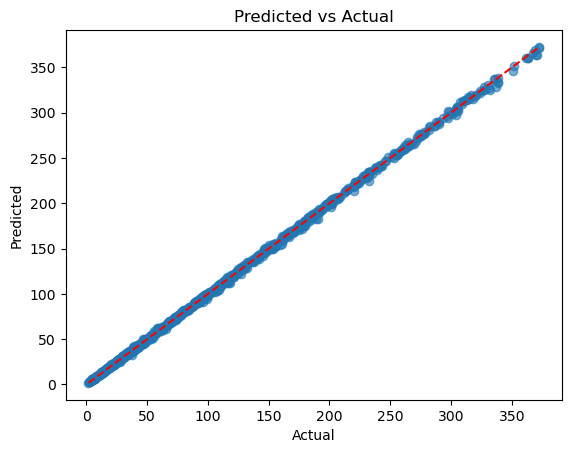

In [34]:
# Checking model accuracy
y_pred = best_rf_model.predict(X_test_capped)
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # line y=x
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual")
plt.show()

**Predicted vs Actual**

Plot tersebut digunakan untuk mengevaluasi seberapa akurat prediksi model dengan nilai aktualnya. Yang mana sumbu x merupakan nilai aktual dari data (y_test), dan sumbu y merupakan nilai yang diprediksi model (y_pred). Dari grafik tersebut dapat dilihat bahwa titik-titik biru sangat dekat dengan garis merah, yang artinya model sudah memprediksi nilai dengan benar (akurasi tinggi, model stabil).

## **ALTERNATIVE MODEL**

Karena nilai MAE pada data train dan test menunjukkan adanya overfitting meskipun skor R2 cukup bagus, kami memutuskan untuk mencoba model lain sebagai alternatif. Model yang dipilih yaitu LinearRegression.

In [35]:
pipe_lr.fit(X_train_capped, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['revenue', 'ad_ctr',
                                                   'ad_cpc']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['category', 'region'])])),
                ('linearregression', LinearRegression())])

In [36]:
y_train_pred_lr = pipe_lr.predict(X_train_capped)
y_test_pred_lr = pipe_lr.predict(X_test_capped)

In [37]:
# Evaluate
all_reports = {}
all_reports = performance_report(all_reports, y_train, y_train_pred, y_test, y_test_pred, "RandomForestRegressor before tuned")
all_reports = performance_report(all_reports, y_train, y_train_pred_tuned, y_test, y_test_pred_tuned, "RandomForestRegressor after tuned")
all_reports = performance_report(all_reports, y_train, y_train_pred_lr, y_test, y_test_pred_lr, "LinearRegression")

pd.DataFrame(all_reports)

,RandomForestRegressor before tuned,RandomForestRegressor after tuned,LinearRegression
Train MAE,0.44060,0.39974,22.65343
Test MAE,1.13597,1.07711,23.12177
Train R2,0.99994,0.99995,0.87893
Test R2,0.99966,0.99969,0.87935


Dari hasil training pada model LinearRegression, didapatkan insight sebagai berikut:
- Selisih nilai MAE pada data train dan test hanya sebesar 0.46834 (goodfit), yang menunjukkan bahwa model tidak mengalami overfitting seperti yang terjadi pada model RandomForestRegressor
- Skor R2 juga tergolong cukup baik dan mendekati angka 1, meskipun tidak setinggi skor yang diperoleh oleh model RandomForestRegressor

Berdasarkan perbandingan metrik evaluasi tersebut, kami memutuskan untuk menggunakan model LinearRegression untuk proses prediksi selanjutnya.

## **SAVING MODEL**

In [38]:
# Save model
with open('model_lr.pkl', 'wb') as file:
    pickle.dump(pipe_lr, file)

## **CONCLUSION**

Berdasarkan seluruh proses pemodelan yang telah dilakukan, maka dapat disimpulkan beberapa hal sebagai berikut:
- Model RandomForestRegressor telah menunjukkan performa yang baik dalam melakukan prediksi. Namun, masih terdapat indikasi overfitting yang dapat dilihat pada nilai MAE pada data train dan test. Oleh karena itu, disarankan untuk menambahkan variasi parameter saat proses tuning, atau mempertimbangkan penggunaan model yang lebih sederhana untuk menghindari overfitting
- Dengan mempertimbangkan hasil evaluasi, kami memutuskan untuk menggunakan model yang lebih stabil, yaitu LinearRegression. Meskipun nilai MAE pada data train dan test masih cukup tinggi (jauh dari 0). Oleh karena itu, disarankan untuk mengimplementasikan model regresi terregularisasi seperti LassoRegression, RidgeRegression, atau Elastic Net, serta melakukan hyperparameter tuning yang sesuai untuk mendapatkan performa model yang lebih optimal